In [1]:
import seaborn as sns
import scipy.optimize
import scipy.interpolate
from ipywidgets import interact
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Vehicle definition

In [2]:
m = 1.4e3  # [kg] - effective vehicle mass
c_r = 12e-3  # [-] - tire rolling resistance coefficient
c_D = 0.3  # [-] - aerodynamic drag coefficient
A_f = 2.2  # [m^2] - frontal area

P_max = 100e3  # [W] - maximum powertrain output power
mu_max = 1  # [-] - maximum tire adhesion coefficient

rho = 1.2  # [kg/m^3] - density of ambient air
g = 9.81  # [m/s^2] - earth acceleration

# Propulsion power without acceleration

The fastest this vehicle can hope to travel on a flat road is when $P = P_{max}$:

In [3]:
def f(v_max):
    return (rho * c_D * A_f / 2 * v_max**3 + m * g * c_r * v_max) - P_max
ret = scipy.optimize.root(f, 200/3.6)
assert ret.success
v_max = ret.x[0]
print("maximum speed: {:.1f} km/h".format(v_max * 3.6))

maximum speed: 219.6 km/h


The following is a graphical interpretation of what happens above. Notice that for $v < v_{max}$, we have additional power available - the power margin - that we can use to accelerate. In the next section, we are going to explore how much acceleration this gives us.

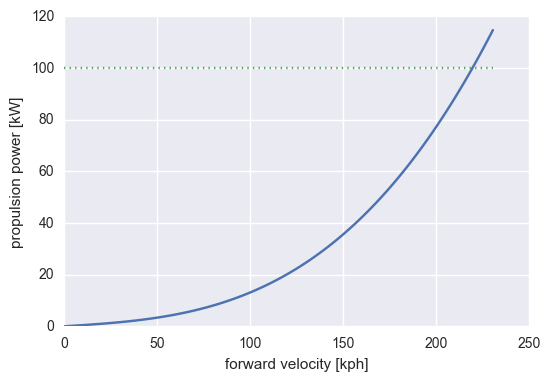

In [4]:
v = np.linspace(0, v_max * 1.05, 100)
P_noAcc = rho * c_D * A_f / 2 * v**3 + m * g * c_r * v

ax = plt.subplot(111)
ax.plot(v*3.6, P_noAcc*1e-3)
ax.set_xlabel("forward velocity [kph]")
ax.set_ylabel("propulsion power [kW]")

ax.plot([0, v[-1]*3.6], np.ones(2) * P_max*1e-3, ":");

## Acceleration reserve

Generally we have:
$$m \cdot \frac{dv(t)}{dt} = F_{prop}(u, v) - F_{aero}\left(v(t)\right) - F_{roll}\left(v(t)\right)$$
where $F_{prop}$ is the modulable force output of the powertrain (symbolized by the control signal $u$, which corresponds to the accelerator setting):
$$F_{prop}(u, v) = F_{max}(v, \ldots) \cdot u$$
where $F_{max}$ is the maximum force the powertrain can produce. As we will see, $F_{max}$ is generally a speed-dependent property - it can also depend on internal states of the powertrain, such as the engine temperature or the battery state of charge. But for now, to keep things lean, we'll assume it's just a constant.

On a flat road (and if there is no wind), the minimal power to maintain a constant cruising velocity $v$ is:
$$F_{prop} \cdot v = F_{aero}\left(v\right) \cdot v - F_{roll}\left(v\right) \cdot v$$
Just as the force output of the powertrain is limited, so is its poweroutput:
$$P_{prop} = F_{prop}(u) \cdot v(t) \leq P_{max}$$
As long as $P_{prop} < P_{max}$ there is a power reserve, which can be invested into acceleration. If we invest the full margin when cruising at a constant velocity $v$, the maximum acceleration $a_{max}$ the vehicle can produce is given by:
$$m \cdot a_{max} \cdot v = P_{max} - P_{prop}(v) \Rightarrow a_{max}(v) = \frac{P_{max} - P_{prop}(v)}{m \cdot v}$$

At low speeds, another limitation can kick in: the tires can only transmit so much force before they start skidding. The maximum force a tire can transmit in any horizontal direction is expressed through the adhesion coefficient $\mu_{max}$, defined by:
$$\mu_{max} = \frac{F_{max}}{m \cdot g}$$
The adhesion coefficient is a property of the tire-road interface; next to the tire, it depends on the nature (e.g. paved vs. gravel roads) and condition (e.g. dry vs. wet) of the road surface. Under ideal conditions, on a clean, dry road with warm tires that are neither worn out nor still running in, $\mu_{max} \approx 1$.

We thus have an additional constraint:
$$F_{prop}(u, v) \leq m \cdot g \cdot \mu_{max}$$

It limits $a_{max}$ through force at low speeds, when the power constraint is not yet active:
$$a_{max} = g \cdot \mu_{max} - \frac{1}{m} \cdot F_{aero}\left(v(t)\right) - \frac{1}{m} \cdot F_{roll}\left(v(t)\right)$$


At stand-still this simplifies to:
$$a_{max} = (\mu_{max} - c_r) \cdot g$$

(0, 1)

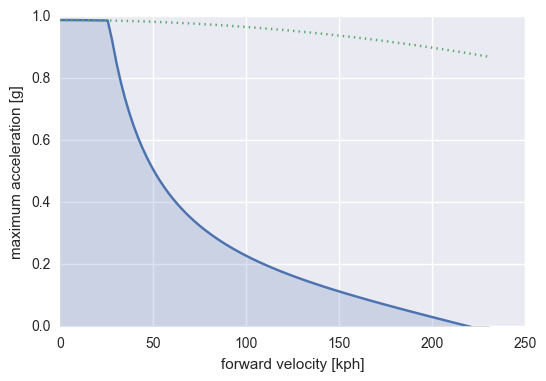

In [5]:
P_reserve = P_max - P_noAcc
a_power = P_reserve / m / v

a_adhesion = mu_max * g - (rho * c_D * A_f / 2 * v**2) / m - (g * c_r)

a_max = np.minimum(a_power, a_adhesion)

ax = plt.subplot(111)
ax.plot(v*3.6, a_max / g)
ax.plot(v*3.6, a_adhesion / g, ":")
ax.fill_between(v*3.6, np.zeros(v.shape), a_max/g, alpha=0.2)

ax.set_xlabel("forward velocity [kph]")
ax.set_ylabel("maximum acceleration [g]");
ax.set_ylim([0, mu_max])

For most passenger cars, the power constraint dominates at speeds exceeding some $40\ldots 50 \; km/h$. The adhesion limit is thus not so much of a practical concern. With high-performance cars though, the powerful engines push the onset of the power limitation to much higher speeds. In that case, slicks maximize the amount of force closure, and thus directly increase $\mu_{max}$ (to a certain limit). Beyond that, automotive wings (aerodynamic devices producing downforce, which is not the same as a spoiler) can be used to increase the normal force on the tires.

## Adding an engine map
Now in a real system, we have an engine or motor and possibly a gear-box - we will asssume a naturally aspirated gasoline engine in the following. The rotation speeds and the torque output of the engine are limited; in particular is the maximum torque dependent on the rotation speed:

engine displacement: 1.80L


(0, 180.0)

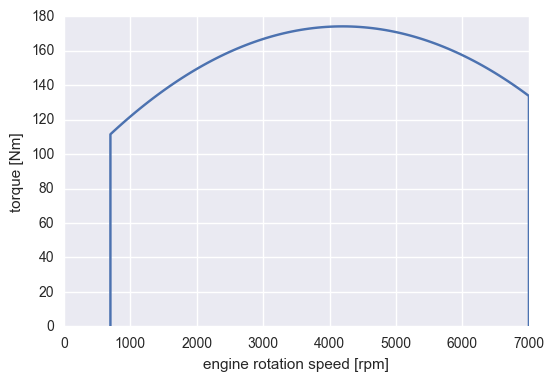

In [6]:
R_dyn = 0.3

rpm = np.linspace(700,7000, 100)
pme_wot = 5.847 + 3e-3 * rpm - 3.5765e-7 * rpm**2

omega = (rpm / 30 * np.pi)

def f(V_H):
    P_wot = (pme_wot * V_H / 4 / np.pi * 1e5) * omega
    return np.max(P_wot) - P_max

ret = scipy.optimize.root(f, 5e-3)
assert ret.success
V_H = ret.x[0]
print("engine displacement: {:.2f}L".format(V_H*1e3))
    
T_wot = pme_wot * V_H / 4 / np.pi * 1e5
P_wot = T_wot * omega
omega_max = omega[np.argmax(P_wot)]

ax = plt.subplot(111)
ax.plot(np.hstack((rpm[0], rpm, rpm[-1])), np.hstack((0, T_wot, 0)))
ax.set_xlabel("engine rotation speed [rpm]")
ax.set_ylabel("torque [Nm]")
ax.set_ylim([0, np.ceil(np.max(T_wot)/10)*10])

This rotation speed is not enough to cover the full range of vehicular motion.
Assuming a wheel radius $R_{dyn} = 30 \; cm$, a direct connection to the wheel would translate the idling and maximum speeds of $700 \; rpm$ and $7000 \; rpm$ to:

In [7]:
print("wheel spinning at 700 rpm --> {:.2f} km/h".format((700 / 30 * np.pi) * R_dyn / 3.6))
print("wheel spinning at 7000 rpm --> {:.2f} km/h".format((7000 / 30 * np.pi) * R_dyn / 3.6))

wheel spinning at 700 rpm --> 6.11 km/h
wheel spinning at 7000 rpm --> 61.09 km/h


A transmission (of gear ratio $\gamma$) would allow to shift that range; it enters the above expression as an additional multiplier after $R_{dyn}$:
$$v = \omega \cdot R_{dyn} \cdot \gamma^{-1}$$
Now in practice a car in Switzerland has to be able to go at least $120 \; km/h$ - this would become possible with a gear ratio of:

In [8]:
gamma = (7000 / 30 * np.pi) * R_dyn / (120 / 3.6)
gamma

6.5973445725385655

The $700 \; rpm$ then translate to:

In [9]:
(700 / 30 * np.pi) * R_dyn / gamma * 3.6

12.0

In principle, speeds below $12 \; km/h$ could be handled by a clutch. But the engine does more: through its maximum torque line, it adds a new limitation: we are no longer just power-constrained, but also torque constrained. And as can be seen in the diagram below, this would result in quite poor driveability (we extended the torque at minimal rotation speed to $0 \; km/h$ presuming the action of a clutch: it would transmit torque from the engine to the wheels, with the engine spinning at $700 \; rpm$; this would be faster than the driveshaft, i.e. power is not being conserved.

(0, 1)

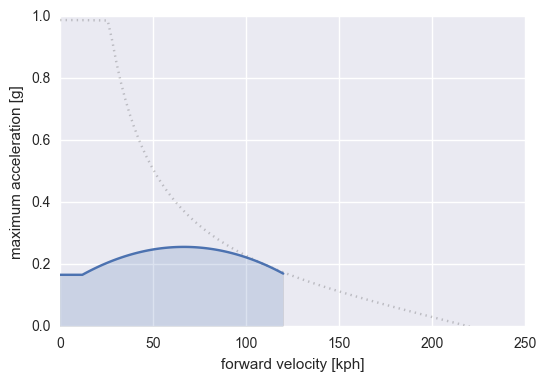

In [10]:
n_gears = 5

ax = plt.subplot(111)
ax.plot(v*3.6, a_max / g, "k:", alpha=0.2)

vv = omega * R_dyn / gamma
F_noAcc = rho * c_D * A_f / 2 * vv**2 + m * g * c_r
F_reserve = T_wot / R_dyn * gamma  - F_noAcc
a = F_reserve / m

# extension of operation field under action of a clutch
vv = np.hstack((0, vv))  # --> we add the point at zero rotation speed
a = np.hstack((a[0], a))  # the same torque can be transmitted, so we get the same acceleration 
ax.plot(vv*3.6, a / g)

ax.fill_between(vv*3.6, np.zeros(vv.shape), a/g, alpha=0.2)

ax.set_xlabel("forward velocity [kph]")
ax.set_ylabel("maximum acceleration [g]");
ax.set_ylim([0, mu_max])

The solution, as we are very used to, is to have multiple gears. Here for example, we take the actual gear ratios of the 2012 Volkswagen Golf (Mk7) 1.4 TSI (103 kW) - specs taken from [cars-data.com](http://www.cars-data.com/en/volkswagen-golf-1.4-tsi-140hp-act-comfortline-specs/59566):

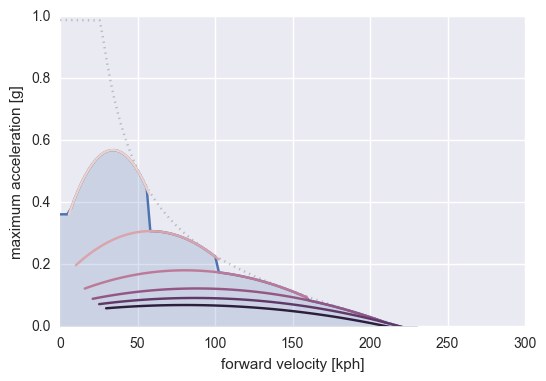

In [11]:
n_gears = 5

ax = plt.subplot(111)
ax.plot(v*3.6, a_max / g, 'k:', alpha=0.2)

gears = np.array([3.78, 2.12, 1.36, 1.03, 0.86, 0.73]) *  3.65

a_torque = np.zeros(v.shape) * np.nan  # vector to retain torque-limited maximum acceleration

for gamma, color in zip(gears, sns.cubehelix_palette(gears.shape[0])):
    vv = omega * R_dyn / gamma
    F_noAcc = rho * c_D * A_f / 2 * vv**2 + m * g * c_r
    F_reserve = T_wot / R_dyn * gamma  - F_noAcc
    a = F_reserve / m
    ax.plot(vv*3.6, a / g, color=color, zorder=10)
    
    # compute new a-max --> interpolate onto 'v' vector
    vv = np.hstack((0, vv))
    a = np.hstack((a[0], a))
    _a = scipy.interpolate.interp1d(vv, a, bounds_error=False)(v)
    filt = np.logical_and(~np.isnan(_a), np.isnan(a_torque))  # replace where _a is defined and a_torque has no value yet
    a_torque[filt] = _a[filt]

ax.plot(v*3.6, a_torque/g, zorder=2)
ax.fill_between(v * 3.6, np.zeros(v.shape), a_torque / g, alpha=0.2, zorder=1)
    
ax.set_xlabel("forward velocity [kph]")
ax.set_ylabel("maximum acceleration [g]");
ax.set_ylim([0, mu_max]);

In order to be able to play with this model, we'll need to make the gear-ratios self-adjusting to a new vehicle. We'll do so by introducing a simple design heuristic:

1. The lowest gear ratio is determined so that the vehicle can cruise at 5 kph without using the clutch, in other words so that we reach an engine speed of $700 \; rpm$ at a driving speed of $5 \; km/h$.
2. The highest gear is chosen so that the rotation speed where the engine reaches maximum power coincides with the vehicle cruising at its maximum speed $v_{max}$, in other words we want top speed at top gear.

Note that Volkswagen chose a slightly different, but very common approach for their design above: top speed is reached in the 5th gear, but can't be reached in the 6th gear. There are two reasons for chosing such an excessively high top gear: for the same speed, the higher gear ratio results in:

1. a lower engine rotation speed, improving noise emissions and thus making for a more comfortable ride on long-distance, high speed motorway driving.
2. a higher engine load, improving the thermodynamic conversion efficiency.

(0, 1)

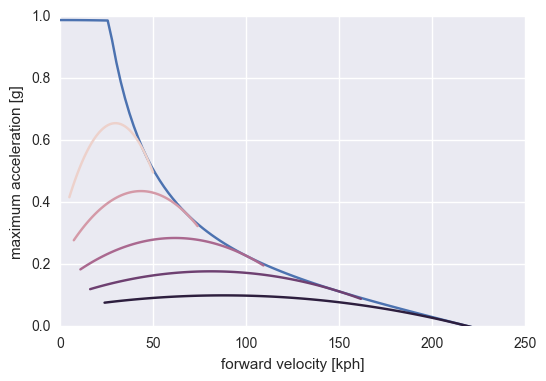

In [12]:
n_gears = 5

ax = plt.subplot(111)
ax.plot(v*3.6, a_max / g)

gmax = omega_max * R_dyn / v_max  # highest gear -> set maximum power point to maximum speed
gmin = omega[0] * R_dyn / (5/3.6)  # lowest gear -> no clutch at 5 kph
r = (gmax / gmin)**(1/(n_gears-1))
gears = np.array([gmin * r ** i for i in range(n_gears)])  # geometric progression

for gamma, color in zip(gears, sns.cubehelix_palette(gears.shape[0])):
    vv = omega * R_dyn / gamma
    F_noAcc = rho * c_D * A_f / 2 * vv**2 + m * g * c_r
    F_reserve = T_wot / R_dyn * gamma  - F_noAcc
    a = F_reserve / m
    ax.plot(vv*3.6, a / g, color=color)

ax.set_xlabel("forward velocity [kph]")
ax.set_ylabel("maximum acceleration [g]");
ax.set_ylim([0, mu_max])

## Influence of the shape of the full-load line

### turbo-charged engines (incl. diesel engines)

(0, 280.0)

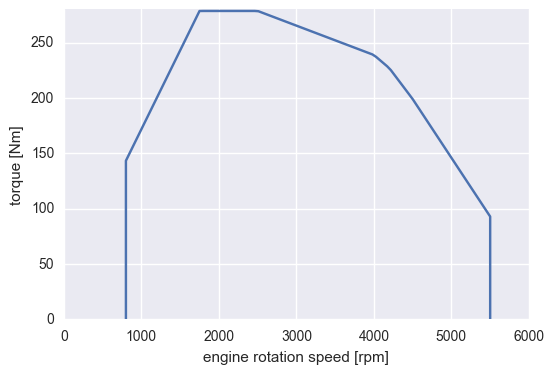

In [13]:
omega = np.linspace(800, 5500, 100) / 30 * np.pi
T_wot = scipy.interpolate.interp1d([800, 1750, 2500, 4000, 4200, 4500, 6000],
                                   [180, 350, 350, 300, 285, 250, 50])(omega * 30 / np.pi)
T_wot *= P_max / np.max(omega * T_wot)  # scale to ensure P_max


ax = plt.subplot(111)
ax.plot(np.hstack((omega[0], omega, omega[-1])) * 30 / np.pi, np.hstack((0, T_wot, 0)))
ax.set_xlabel("engine rotation speed [rpm]")
ax.set_ylabel("torque [Nm]")
ax.set_ylim([0, np.ceil(np.max(T_wot)/10)*10])

(0, 1)

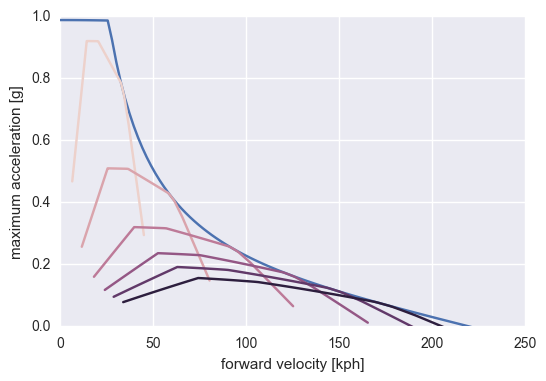

In [14]:
ax = plt.subplot(111)
ax.plot(v*3.6, a_max / g)

gears = np.array([3.78, 2.12, 1.36, 1.03, 0.86, 0.73]) *  3.65

for gamma, color in zip(gears, sns.cubehelix_palette(gears.shape[0])):
    vv = omega * R_dyn / gamma
    F_noAcc = rho * c_D * A_f / 2 * vv**2 + m * g * c_r
    F_reserve = T_wot / R_dyn * gamma  - F_noAcc
    a = F_reserve / m
    ax.plot(vv*3.6, a / g, color=color)

ax.set_xlabel("forward velocity [kph]")
ax.set_ylabel("maximum acceleration [g]");
ax.set_ylim([0, mu_max])

### electric machinery

The full-load line of electric machinery is virtually independent of the rotation speed to the point where the engine reaches its nominal peak-power. Then, the power-constraint induces a hyperbolic shape:

(0, 300.0)

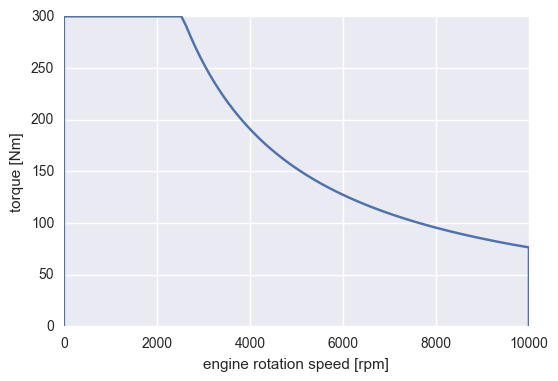

In [61]:
omega = np.linspace(0, 10000, 100) / 30 * np.pi
T_wot = np.ones(100) * 300
filt = T_wot * omega > 80e3
T_wot[filt] = 80e3 / omega[filt]

ax = plt.subplot(111)
ax.plot(np.hstack((0, omega, omega[-1])) * 30/np.pi, np.hstack((0, T_wot, 0)))
ax.set_xlabel("engine rotation speed [rpm]")
ax.set_ylabel("torque [Nm]")
ax.set_ylim([0, np.ceil(np.max(T_wot)/10)*10])

The electric machine can be coupled directly to the wheel, as it is able to produce torque at zero rotation speed. Still, a single-stage transmission is necessary to adjust the motor rotation speed spectrum to the needs of the vehicle:

(0, 1)

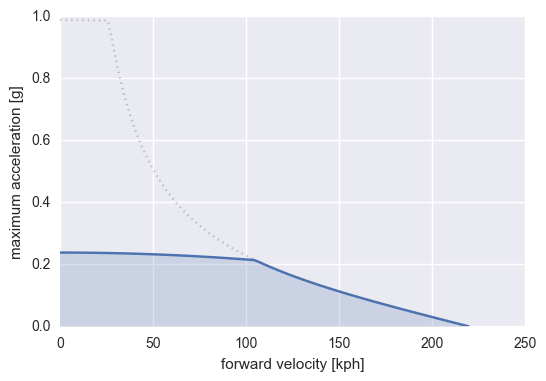

In [16]:
gamma = omega[-1] * R_dyn / v_max  # set ratio so that maximum engine speed reached at vehicle's top speed

ax = plt.subplot(111)
ax.plot(v*3.6, a_max / g, "k:", alpha=0.2)

vv = omega * R_dyn / gamma
F_noAcc = rho * c_D * A_f / 2 * vv**2 + m * g * c_r
F_reserve = T_wot / R_dyn * gamma  - F_noAcc
a = F_reserve / m

# extension of operation field under action of a clutch
vv = np.hstack((0, vv))  # --> we add the point at zero rotation speed
a = np.hstack((a[0], a))  # the same torque can be transmitted, so we get the same acceleration 
ax.plot(vv*3.6, a / g)

ax.fill_between(vv*3.6, np.zeros(vv.shape), a/g, alpha=0.2)

ax.set_xlabel("forward velocity [kph]")
ax.set_ylabel("maximum acceleration [g]");
ax.set_ylim([0, mu_max])

# Putting it all into a dynamic function

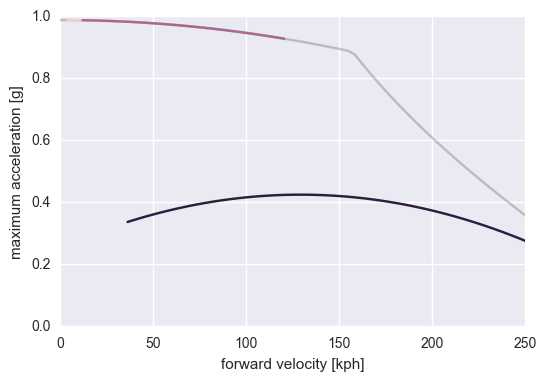

In [115]:
@interact(P_max=(10, 600, 5), m=(500, 40e3, 100), n_gears=(1, 8, 1), engine=["naturally aspirated", "turbocharged", "electric"])
def plot(P_max=75, m=1.4e3,n_gears=5, engine="naturally aspirated", scale_by_volume=False):
    P_max *= 1e3
    height = 160e-2
             
    c_r = 12e-3
    c_D = 0.27
    A = 2*height
    A_f = 2-1.23069 + 11e-5*m + 1.304851*A -0.05398*A**2
    mu_max = 1.0
    R_dyn = 0.3
    
    rho = 1.2
    g = 9.81
    
    # determine maximum speed
    def f(v_max):
        return (rho * c_D * A_f / 2 * v_max**3 + m * g * c_r * v_max) - P_max
    ret = scipy.optimize.root(f, 200/3.6)
    assert ret.success
    v_max = ret.x[0]
    
    # maximum acceleration line due to power and grip limitation
    v = np.linspace(0, v_max, 100)
    P_noAcc = rho * c_D * A_f / 2 * v**3 + m * g * c_r * v
    a_power = (P_max - P_noAcc) / m / v
    a_adhesion = mu_max * g - (rho * c_D * A_f / 2 * v**2) / m - (g * c_r)
    a_max = np.minimum(a_power, a_adhesion)
   
    # size the engine
    if engine == "naturally aspirated":
        rpm = np.linspace(700,7000, 100)
        pme_wot = 5.847 + 3e-3 * rpm - 3.5765e-7 * rpm**2
        omega = (rpm / 30 * np.pi)
        T_wot = pme_wot * 1.8e-3 / 4 / np.pi * 1e5
    
    elif engine == "electric":
        omega = np.linspace(0, 9000, 100) / 30 * np.pi
        T_wot = np.ones(100) * 280  # roughly the nissan leaf's traction motor 
        filt = T_wot * omega > 80e3
        T_wot[filt] = 80e3 / omega[filt]
    
    elif engine == "turbocharged":
        omega = np.linspace(800, 5500, 100) / 30 * np.pi
        T_wot = scipy.interpolate.interp1d([800, 1750, 2500, 4000, 4200, 4500, 6000],
                                           [180, 350, 350, 300, 285, 250, 50])(omega * 30 / np.pi) 
    else:
        raise ValueError("unknown engine")
        
    # scale to P_max - scaling by volume
    _gamma = P_max / np.max(omega * T_wot)
    if scale_by_volume:  # use "Ähnlichkeitsbeziehungen"
        T_wot *=  _gamma**(3/2)
        omega /= np.sqrt(_gamma)
    else:  # equiv. to increasing the number of cylinders (or bmep) 
        T_wot *= _gamma         
        
    # speed at nominal power (deal with el. machinery, where the maximum is a line, not a point)
    idx = np.nonzero(np.isclose(omega * T_wot, np.max(omega * T_wot)))[0][-1]  # chose highest speed
    omega_max = omega[idx]
    
    # design the gear-box
    gmax = omega_max * R_dyn / v_max  # highest gear -> set maximum power point to maximum speed
    alpha_max = np.arctan(0.44)  # be able to drive away in a 44% slope (results in an "accel. equiv." of ~0.4)
    gmin =  m * g * (c_r * np.cos(alpha_max)  + np.sin(alpha_max)) / T_wot[0] * R_dyn
    gmin_bis = omega[0] * R_dyn / (4/3.6) # lowest gear -> no clutch at 4 kph
    gmin = gmin_bis if gmin_bis > gmin else gmin 
    r = (gmax / gmin)**(1/(n_gears-1)) if n_gears > 1 else 1
    gears = np.array([gmin * r ** i for i in range(n_gears)])  # geometric progression

    ax = plt.subplot(111)
    ax.plot(v*3.6, a_max / g, "k", alpha=0.2)
    
    for gamma, color in zip(gears, sns.cubehelix_palette(gears.shape[0])):
        vv = omega * R_dyn / gamma
        F_noAcc = rho * c_D * A_f / 2 * vv**2 + m * g * c_r
        F_reserve = T_wot / R_dyn * gamma  - F_noAcc
        aa = scipy.interpolate.interp1d(v, a_max, bounds_error=False)(vv)
        a = np.minimum(F_reserve / m, aa)
        ax.plot(vv*3.6, a / g, color=color)

    ax.set_xlabel("forward velocity [kph]")
    ax.set_ylabel("maximum acceleration [g]");
    ax.set_ylim([0, mu_max])
    ax.set_xlim([0, 250])

In [89]:
np.sin(np.arctan(0.44))

0.40273861426601693

In [86]:
np.tan(np.arcsin(0.4))

0.43643578047198484

In [32]:
        omega = np.linspace(0, 10000, 100) / 30 * np.pi
        T_wot = np.ones(100) * 250
        filt = T_wot * omega > 100e3
        T_wot[filt] = P_max / omega[filt]

In [41]:
np.nonzero(np.isclose(omega * T_wot, np.max(omega * T_wot)))[0]

array([38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
       89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int64)

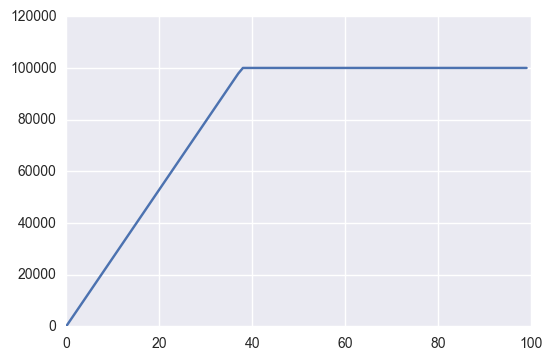

In [39]:
plt.plot(omega * T_wot)